<a href="https://colab.research.google.com/github/kidsage/KaggleStudy/blob/main/Cassava_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c cassava-leaf-disease-classification

 97% 211M/216M [00:01<00:00, 124MB/s]
100% 216M/216M [00:01<00:00, 128MB/s]
 99% 214M/217M [00:01<00:00, 155MB/s]
100% 217M/217M [00:01<00:00, 135MB/s]
 93% 202M/216M [00:01<00:00, 136MB/s]
100% 216M/216M [00:01<00:00, 128MB/s]
 98% 212M/217M [00:01<00:00, 128MB/s]
100% 217M/217M [00:01<00:00, 136MB/s]
 99% 213M/214M [00:02<00:00, 103MB/s]
100% 214M/214M [00:02<00:00, 103MB/s]
 98% 210M/215M [00:01<00:00, 128MB/s]
100% 215M/215M [00:01<00:00, 120MB/s]
 93% 201M/216M [00:01<00:00, 125MB/s]
100% 216M/216M [00:01<00:00, 125MB/s]
 99% 215M/217M [00:02<00:00, 104MB/s] 
100% 217M/217M [00:02<00:00, 104MB/s]
 96% 206M/214M [00:01<00:00, 139MB/s]
100% 214M/214M [00:01<00:00, 126MB/s]
 92% 201M/218M [00:02<00:00, 84.3MB/s]
100% 218M/218M [00:02<00:00, 98.1MB/s]
 93% 200M/216M [00:04<00:00, 59.7MB/s]
100% 216M/216M [00:04<00:00, 47.2MB/s]
 99% 215M/217M [00:04<00:00, 39.0MB/s]
100% 217M/217M [00:05<00:00, 44.6MB/s]
 96% 209M/217M [00:04<00:00, 41.1MB/s]
100% 217M/217M [00:04<00:00, 46.9MB/s]
 97

In [40]:
!unzip ld_train00-1338.tfrec.zip
!unzip ld_train01-1338.tfrec.zip
!unzip ld_train02-1338.tfrec.zip
!unzip ld_train03-1338.tfrec.zip
!unzip ld_train04-1338.tfrec.zip
!unzip ld_train05-1338.tfrec.zip
!unzip ld_train06-1338.tfrec.zip
!unzip ld_train07-1338.tfrec.zip
!unzip ld_train08-1338.tfrec.zip
!unzip ld_train09-1338.tfrec.zip
!unzip ld_train10-1338.tfrec.zip
!unzip ld_train11-1338.tfrec.zip
!unzip ld_train12-1338.tfrec.zip
!unzip ld_train13-1338.tfrec.zip
!unzip ld_train14-1338.tfrec.zip
!unzip ld_train15-1327.tfrec.zip

Archive:  ld_train00-1338.tfrec.zip
replace ld_train00-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train00-1338.tfrec   
Archive:  ld_train01-1338.tfrec.zip
replace ld_train01-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train01-1338.tfrec   
Archive:  ld_train02-1338.tfrec.zip
replace ld_train02-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train02-1338.tfrec   
Archive:  ld_train03-1338.tfrec.zip
replace ld_train03-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train03-1338.tfrec   
Archive:  ld_train04-1338.tfrec.zip
replace ld_train04-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train04-1338.tfrec   
Archive:  ld_train05-1338.tfrec.zip
replace ld_train05-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train05-1338.tfrec   
Archive:  ld_train06-1338.tfrec.zip
replace ld_train06-1338.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ld_train06

In [44]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()

ModuleNotFoundError: ignored

In [9]:
!pip install --quiet efficientnet

     |████████████████████████████████| 50 kB 2.6 MB/s 


In [45]:
import math, os, re, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#from kaggle_datasets import KaggleDatasets
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

In [46]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.85.99.122:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.85.99.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.85.99.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


In [47]:
BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 30
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 5
ES_PATIENCE = 10
N_FOLDS = 5

In [48]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

train = pd.read_csv('train.csv')
print(f'Train samples: {len(train)}')

Train samples: 21397


In [49]:
train

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [50]:
os.getcwd()

'/content'

In [51]:
TRAINING_FILENAMES = tf.io.gfile.glob('/content'+'/*.tfrec')
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

GCS: train images: 21397


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [52]:
TRAINING_FILENAMES

['/content/ld_train10-1338.tfrec',
 '/content/ld_train02-1338.tfrec',
 '/content/ld_train11-1338.tfrec',
 '/content/ld_train04-1338.tfrec',
 '/content/ld_train05-1338.tfrec',
 '/content/ld_train09-1338.tfrec',
 '/content/ld_train15-1327.tfrec',
 '/content/ld_train01-1338.tfrec',
 '/content/ld_train07-1338.tfrec',
 '/content/ld_train14-1338.tfrec',
 '/content/ld_train06-1338.tfrec',
 '/content/ld_train03-1338.tfrec',
 '/content/ld_train08-1338.tfrec',
 '/content/ld_train13-1338.tfrec',
 '/content/ld_train00-1338.tfrec',
 '/content/ld_train12-1338.tfrec']

In [53]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    return image, label

In [54]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [55]:
# Datasets utility functions
def decode_image(image_data):
    """
        1. Decode a JPEG-encoded image to a uint8 tensor.
        2. Cast tensor to float and normalizes (range between 0 and 1).
        3. Resize and reshape images to the expected size.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
                      
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
    else:
        label_or_name =  example['image_name']
    return image, label_or_name

def load_dataset(filenames, labeled=True, ordered=False):
    """
        Create a Tensorflow dataset from TFRecords.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    dataset = load_dataset(FILENAMES, labeled=labeled, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [56]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# EDA

Class map  
>0: Cassava Bacterial Blight (CBB)  
1: Cassava Brown Streak Disease (CBSD)  
2: Cassava Green Mottle (CGM)  
3: Cassava Mosaic Disease (CMD)  
4: Healthy

In [57]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

UnimplementedError: ignored

여기서 중요한 것은 이미지 품질이 데이터 세트에 대해 매우 일관성이 있는 것처럼 보인다는 것입니다. 이렇게 하면 모델을 일반화하기가 더 쉬워집니다.

다른 한편으로, 어떤 이미지는 많은 잎을 가지고 있고, 어떤 것은 식물에서 멀리 떨어져 있고, 어떤 것은 잎이 전혀 없습니다

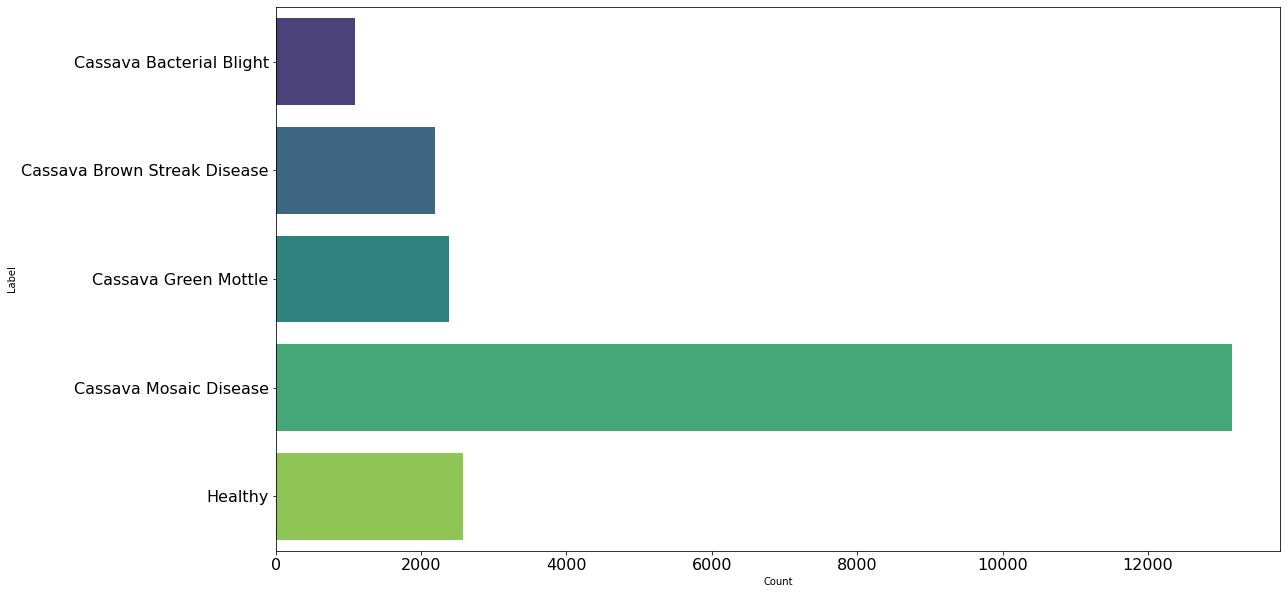

In [32]:
label_count = train.groupby('label', as_index=False).count()
label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

데이터 세트가 매우 불균형한 것을 볼 수 있듯이 대부분의 샘플은 Cassava Mosaic Disease에 속하지만 다른 모든 클래스 크기는 훨씬 더 가깝습니다.

**Learning rate schedule**

워밍업 단계와 함께 코사인 learning rate를 사용할 것입니다. 사전 훈련된 모델을 사용하기 때문에 이것은 좋은 생각일 수 있습니다.  
워밍업 단계는 사전 훈련된 가중치 저하로 인한 결과를 방지하는 데 유용할 것입니다.  
치명적인 망각의 경우 일정 동안 학습률이 매우 낮은 값으로 천천히 감소하므로 모델이 더 안정적인 가중치에 착륙하는 데 도움이 됩니다.

30 total epochs and 1337 steps per epoch
Learning rate schedule: 1e-08 to 3e-05 to 1.01e-07


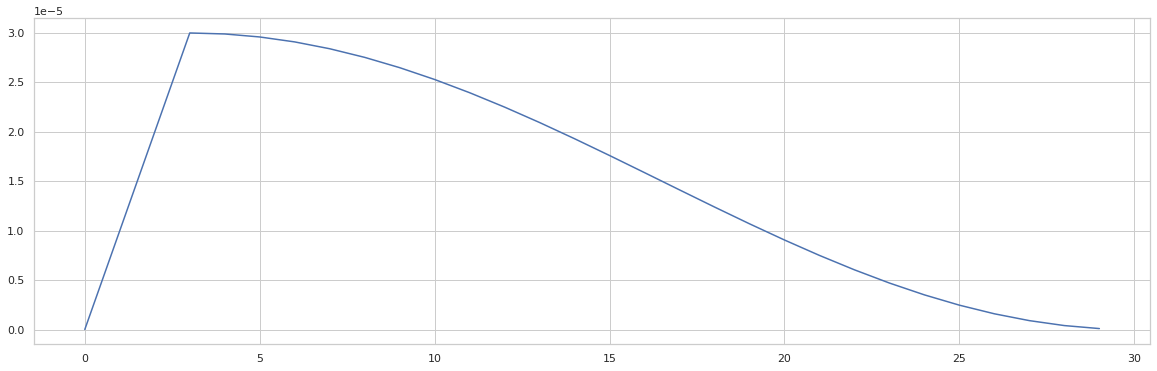

In [33]:
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

여기에서 저는 EfficientNet을 사용하고 있습니다.  
많은 인기 있는 컴퓨터 비전 모델과 비교하여 ImageNet의 매개변수 수와 정확도 사이에 매우 좋은 절충점이 있습니다.

>https://github.com/qubvel/efficientnet

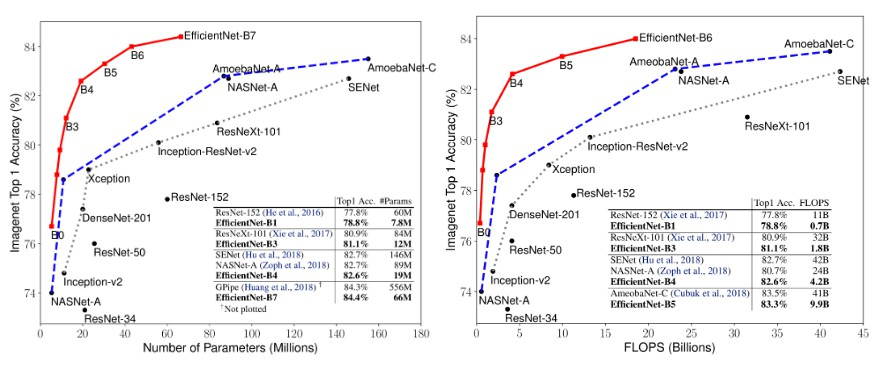

In [34]:
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')

    model = Sequential([
                base_model,
                L.Dropout(.25),
                L.Dense(N_CLASSES, activation='softmax', name='output')
            ])

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=['sparse_categorical_accuracy'])
    
    return model

# Training


In [36]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = tf.io.gfile.glob(['Id_train%.2i*.tfrec' % x for x in idxT])
    VALID_FILENAMES = tf.io.gfile.glob(['Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAINING_FILENAMES)
    ct_train = count_data_items(TRAIN_FILENAMES)
    
    ## MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(TRAIN_FILENAMES, labeled=True, ordered=False, repeated=True, augment=True), 
                        validation_data=get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False), 
                        steps_per_epoch=(ct_train // BATCH_SIZE), 
                        callbacks=[es, LearningRateScheduler(lrfn, verbose=0)], 
                        epochs=EPOCHS,  
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, image_name: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))
    
    ## RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_sparse_categorical_accuracy']):.3f}")


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]


ValueError: ignored

In [ ]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

이제 모델의 성능을 평가할 수 있습니다. 먼저 정확도, 정밀도, 재현율 및 f1 점수와 같은 일반적인 메트릭을 평가할 수 있습니다. scikit-learn은 이 분류 보고서에 대한 완벽한 기능을 제공합니다.

우리는 OOF 예측에 대한 모델을 평가하고 있습니다. 이는 Out Of Fold를 의미합니다. K-Fold를 사용하여 훈련하기 때문에 모델은 모든 데이터를 볼 것이며 각 폴드를 평가하는 올바른 방법은 그렇지 않은 예측을 보는 것입니다. 그 폴드에서.

**OOF metrics**

In [ ]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)

print(classification_report(y_true, y_preds, target_names=CLASSES))

**Confusion matrix**

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
train_cfn_matrix = confusion_matrix(y_true, y_preds, labels=range(len(CLASSES)))
train_cfn_matrix = (train_cfn_matrix.T / train_cfn_matrix.sum(axis=1)).T
train_df_cm = pd.DataFrame(train_cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(train_df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

마지막으로, 항상 데이터를 보고 모델의 예측 중 일부를 검사하는 것이 좋습니다.  
데이터가 정말 어렵기 때문에 모델이 일부 예측을 잘못하고 있을 수 있습니다. 모델이 실제로 좋지 않은 경우에.

Class map

>0: Cassava Bacterial Blight (CBB)  
1: Cassava Brown Streak Disease (CBSD)  
2: Cassava Green Mottle (CGM)  
3: Cassava Mosaic Disease (CMD)  
4: Healthy  

**Train set**

In [ ]:
x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)